# Logistic Regression (Regularised)

## Introduction

In this example, we will implement regularized logistic regression
to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests,
you would like to determine whether the microchips should be accepted or
rejected. To help you make the decision, you have a dataset of test results
on past microchips, from which you can build a logistic regression model.

## Visualizing the data

Before starting to implement any learning algorithm, it is always good to
visualize the data if possible.

The file 'data/ex2data2.txt' contains the dataset for our Logistic regression problem.

Here we will load the data and display it on a 2-dimensional plot, where the axes are the two exam scores, and the positive and
negative examples are shown with different markers.

In [1]:
# initial imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
import seaborn as sns

# setting graph properties
plt.rcParams['figure.dpi'] = 300  # setting figure dpi for better quality graphs
plt.rcParams['figure.figsize'] = [10,8]
sns.set(context="notebook", style="white")  # graph styling using seaborn
%config InlineBackend.figure_format = 'pdf'

In [2]:
# imports from my models designed for these examples
from models.data_preprocessing import add_bias_unit, map_feature, feature_normalize
from models.logistic_regression import cost_function, predict, gradient_descent, gradient_function, sigmoid
from models.plotter import plot_decision_boundary

In [3]:
print('Loading data ...')
data = np.loadtxt('data/ex2data2.txt', delimiter=',')
X = data[:, :-1]  # (118, 2)
y = data[:, -1, np.newaxis]  # (118, 1)

Loading data ...


Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.


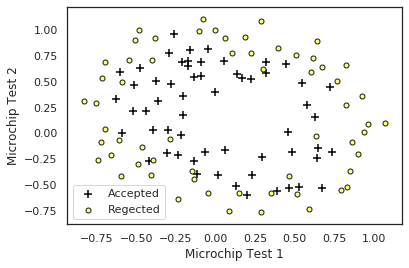

In [4]:
print('Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.')
"""
Example plotting for multiple markers
x = np.array([1,2,3,4,5,6])
y = np.array([1,3,4,5,6,7])
m = np.array(['o','+','+','o','x','+'])

unique_markers = set(m)  # or yo can use: np.unique(m)

for um in unique_markers:
    mask = m == um 
    # mask is now an array of booleans that van be used for indexing  
    plt.scatter(x[mask], y[mask], marker=um)
"""
fig, ax = plt.subplots()
y_slim = y.ravel()
# plotting y=1 values
ax.scatter(x=X[y_slim == 1, 0], y=X[y_slim == 1, 1], marker='+', c='black', s=50, label='Accepted')
# plotting y=0 values
# X[y_slim == 0, 0] is logical indexing with rows with y=0 only
ax.scatter(x=X[y_slim == 0, 0], y=X[y_slim == 0, 1], marker='o', c='xkcd:light yellow', s=25, label='Regected', edgecolor='k')

# labels
ax.set_xlabel('Microchip Test 1')
ax.set_ylabel('Microchip Test 2')

# Specified in plot order
ax.legend()

Figure shows that our dataset cannot be separated into positive and
negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

## Feature Mapping

One way to fit the data better is to create more features from each data
point. In the function map_features(), we will map the features into
all polynomial terms of $x_{1}$ and $x_{2}$ up to the sixth power.

$$
mapFeature(x, 6) = 
\begin{bmatrix} 
1 \\
x_{1} \\
x_{2} \\
x_{1}^{2} \\
x_{1} x_{2} \\
x_{2}^{2} \\
x_{1}^{3} \\
\vdots \\
x_{1}x_{2}^{5} \\
x_{2}^{6}\\
\end{bmatrix}
$$

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier,
it also more susceptible to overfitting. In the next parts of the example, we
will implement regularized logistic regression to fit the data and also you will be able to see how regularization can help combat the overfitting problem.

In [5]:
# Adding Polynomial Features

# Note that mapFeature also adds a column of ones for us, so the intercept term is handled
X = map_feature(X, degree=6)

### Cost Function and Gradient

The **regularized** cost function for logistic regression is:

$$
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\left[ -y^{(i)} \log\left( h_{\theta} \left( x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_{\theta} \left( x^{(i)} \right) \right) \right]+\frac{\lambda}{2m} \sum^{n}_{j=1}\theta_{j}^{2}
$$

Note that you should not regularize the parameter θ0. In Octave/MATLAB, recall that indexing starts from 1, hence, you should not be regularizing
the theta(1) parameter (which corresponds to θ0) in the code. The gradient
of the cost function is a vector where the j
th element is defined as follows:

$$\begin{align}
\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right)x_{j}^{(i)} && for j=0\\
\frac{\delta J(\theta)}{\delta \theta_{j}} = \left(\frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right)x_{j}^{(i)}\right)+\frac{\lambda}{m}\theta_{j} && for j >= 1 \\
\end{align}
$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of h$_{θ}$(x).

In [6]:
# initial sizes
m, n = X.shape

# Initialize fitting parameters
initial_theta = np.zeros([n, 1])

# Compute and display initial cost and gradient
cost = cost_function(initial_theta, X, y, regularized=False)
grad = gradient_function(initial_theta, X, y, regularized=False)
print('Cost at initial theta (zeros): {}'.format(cost))
print('Expected cost (approx): 0.693')
print('Gradient at initial theta (zeros) - first five values only:')
print(grad[:5])
print('Expected gradients (approx) - first five values only:')
print('[0.0085 0.0188 0.0001 0.0503 0.0115]')

test_theta = np.ones([X.shape[1], 1])
cost = cost_function(test_theta, X, y, lamda=10, regularized=True)
grad = gradient_function(test_theta, X, y, lamda=10, regularized=True)

print('Cost at test theta (with lambda = 10): {}'.format(cost))
print('Expected cost (approx): 3.16')
print('Gradient at test theta - first five values only: {}'.format(grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('[0.3460 0.1614 0.1948 0.2269 0.0922]')

Cost at initial theta (zeros): [[0.69314718]]
Expected cost (approx): 0.693
Gradient at initial theta (zeros) - first five values only:
[8.47457627e-03 7.77711864e-05 3.76648474e-02 2.34764889e-02
 3.93028171e-02]
Expected gradients (approx) - first five values only:
[0.0085 0.0188 0.0001 0.0503 0.0115]
Cost at test theta (with lambda = 10): [[3.16450933]]
Expected cost (approx): 3.16
Gradient at test theta - first five values only: [0.34604507 0.19479576 0.24438558 0.18346846 0.19994895]
Expected gradients (approx) - first five values only:
[0.3460 0.1614 0.1948 0.2269 0.0922]


## Learning  parameters using scipy.minimize

In earlier examples, we found the optimal parameters of a linear regression model by implementing gradent descent. I also wrote a cost function and calculated its gradient, then took a gradient descent step accordingly.

This time, instead of taking gradient descent steps, we will use an function called minimize from scipy.optimize module.

The scipy's minimize() function provides a common interface to unconstrained and constrained minimization algorithms for multivariate scalar functions in scipy.optimize.

For logistic regression, we need to optimize the cost function J(θ) with parameters θ. Concretely, we are going to use minimize to find the best parameters θ for the logistic regression cost function, given a fixed dataset (of X and y values).
You will pass to minimize() the following inputs:
- Our predefined cost_function which returns cost while taking X and theta as arguments.
- A gradient_function which returns the derivatives of the $\theta$ values passed to it.
- The initial values of the parameters we are trying to optimize.
- A function that, when given the training set and a particular θ, computes the logistic regression cost and gradient with respect to θ for the dataset (X, y)
- A callbak function which is called after each iteration and the $\theta$ value obtained after each iteration is passed to it, we are using this callback function to store theta values for each iteration.

The minimize() function returns a OptimizeResult object which contains final theta values, function end status, final cost etc.
more info about the minimize function can be refered to the documentation <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">here</a>.

Cost at theta found by Gradient descent: [0.52900273]
theta: [ 1.27271026  1.18111686 -1.43166929 -0.17516292 -1.19271298 -0.45645981
 -0.92467487  0.62529965 -0.91743189 -0.35725404 -0.27469165 -0.29539514
 -0.14389149 -2.01987399 -0.36553118 -0.61558557 -0.27778948 -0.32742404
  0.12393227 -0.05098418 -0.04466178  0.01555759 -1.45817009 -0.20603302
 -0.29244866 -0.2421784   0.02779373 -1.04319154]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2c54487f0>)

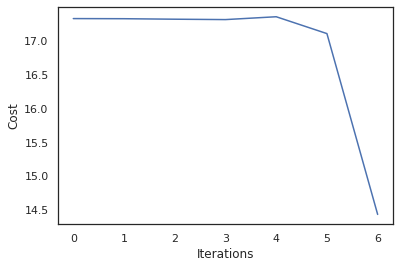

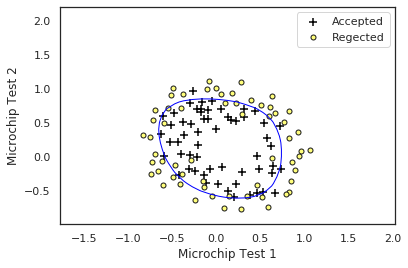

In [7]:
X_norm, mu, sigma = feature_normalize(X[:, 1:])
X_norm = add_bias_unit(X_norm)

from scipy.optimize import minimize

theta_history = []  # for plotting cost vs iteration graph


def theta_store(value, *args):
    theta_history.append(value)


initial_theta = np.zeros(n)
op_result = minimize(fun=cost_function, x0=initial_theta, jac=gradient_function, args=(X, y, 1, True), method='tnc', callback=theta_store)


print('Cost at theta found by Gradient descent: {}'.format(op_result.fun))
print('theta: {}'.format(op_result.x))

# converting theta_history into J_history
J_history = (np.array(theta_history[::-1]) @ op_result.x)

# plot J_history
fig1, ax1 = plt.subplots()
ax1.plot(range(J_history.size), J_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cost')

fig2, ax2 = plt.subplots()
X_old = data[:, :-1]  # (118, 2)
y_old = data[:, -1, np.newaxis]  # (118, 1)
y_slim = y_old.ravel()
# plotting y=1 values
ax2.scatter(x=X_old[y_slim == 1, 0], y=X_old[y_slim == 1, 1], marker='+', c='black', s=50, label='Accepted')
# plotting y=0 values
# X[y_slim == 0, 0] is logical indexing with rows with y=0 only
ax2.scatter(x=X_old[y_slim == 0, 0], y=X_old[y_slim == 0, 1], marker='o', c='xkcd:light yellow', s=25, label='Regected', edgecolor='k')

# labels
ax2.set_xlabel('Microchip Test 1')
ax2.set_ylabel('Microchip Test 2')

# Specified in plot order
ax2.legend()

theta = op_result.x[:,np.newaxis]
plot_decision_boundary(theta=theta, X=X, y=y, hypothesis=sigmoid, precision=0.1, fig=fig2, ax=ax2, feature_map=(map_feature, 6))


## Influence of labda values

In this part of the example, we will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

### No regularization (Overfitting) ($\lambda = 0$)

/home/mayank/PycharmProjects/machine_learning_implementations_with_numpy/models/logistic_regression.py:12: RuntimeWarning: overflow encountered in exp
  g = 1.0/(np.exp(-1*z)+1)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2c51accc0>)

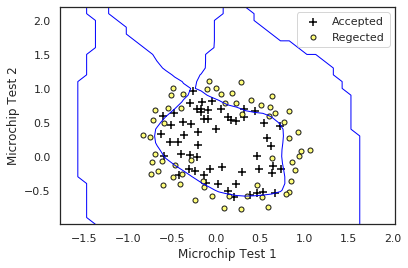

In [8]:
initial_theta = np.zeros(n)
op_result = minimize(fun=cost_function, x0=initial_theta, jac=gradient_function, args=(X, y, 0.0001, True), method='tnc')  # lambda is zero in the args tuple

fig3, ax3 = plt.subplots()
# plotting y=1 values
ax3.scatter(x=X_old[y_slim == 1, 0], y=X_old[y_slim == 1, 1], marker='+', c='black', s=50, label='Accepted')
# plotting y=0 values
# X[y_slim == 0, 0] is logical indexing with rows with y=0 only
ax3.scatter(x=X_old[y_slim == 0, 0], y=X_old[y_slim == 0, 1], marker='o', c='xkcd:light yellow', s=25, label='Regected', edgecolor='k')

# labels
ax3.set_xlabel('Microchip Test 1')
ax3.set_ylabel('Microchip Test 2')

# Specified in plot order
ax3.legend()

theta = op_result.x[:,np.newaxis]
plot_decision_boundary(theta=theta, X=X, y=y, hypothesis=sigmoid, precision=0.1, fig=fig3, ax=ax3, feature_map=(map_feature, 6))


Notice the changes in the decision boundary as you vary λ. With a small
λ, you should find that the classifier gets almost every training example
correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts
that a point at x = (−0.25, 1.5) is accepted (y = 1), which seems to be an incorrect decision given the training set.

### Too much regularization (Underfitting) ($\lambda = 100$)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2c5136080>)

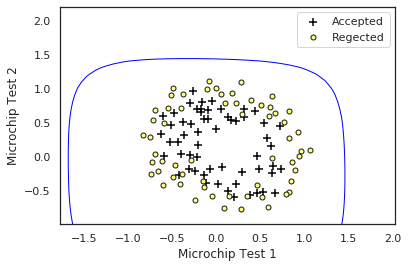

In [9]:
initial_theta = np.zeros(n)
op_result = minimize(fun=cost_function, x0=initial_theta, jac=gradient_function, args=(X, y, 100, True), method='TNC')  # lambda is zero in the args tuple

fig4, ax4 = plt.subplots()
# plotting y=1 values
ax4.scatter(x=X_old[y_slim == 1, 0], y=X_old[y_slim == 1, 1], marker='+', c='black', s=50, label='Accepted')
# plotting y=0 values
# X[y_slim == 0, 0] is logical indexing with rows with y=0 only
ax4.scatter(x=X_old[y_slim == 0, 0], y=X_old[y_slim == 0, 1], marker='o', c='xkcd:light yellow', s=25, label='Regected', edgecolor='k')

# labels
ax4.set_xlabel('Microchip Test 1')
ax4.set_ylabel('Microchip Test 2')

# Specified in plot order
ax4.legend()

theta = op_result.x[:,np.newaxis]
plot_decision_boundary(theta=theta, X=X, y=y, hypothesis=sigmoid, precision=0.1, fig=fig4, ax=ax4, feature_map=(map_feature, 6))

With a larger λ, you should see a plot that shows an simpler decision
boundary which still separates the positives and negatives fairly well. However, if λ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.